In [237]:
import re
import os
import time
import spacy
import random
import tarfile
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request
import tensorflow as tf
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 1
%aimport HanSequenceLabellingModel, model_components
from HanSequenceLabellingModel import HanSequenceLabellingModel

In [2]:
class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data


example = next(iter(ImdbMovieReviews()))
type(example[0]), type(example[0][0]), type(example[1])

(list, str, bool)

In [3]:
class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
        self.parser = spacy.load('en_vectors_web_lg')
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [76]:
def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

***
***
***
***
***

In [176]:
%%time 
reviews = list(ImdbMovieReviews())
random.shuffle(reviews)
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

CPU times: user 3min 21s, sys: 0 ns, total: 3min 21s
Wall time: 3min 19s


In [238]:
def HAN_model_1(session, restore_only=False, attention=True):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
            attention=attention
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [ ]:
max_iters = 300
tf.reset_default_graph()
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.25)
config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, _) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        step, summaries, loss, accuracy, _ = s.run([
                model.global_step,
                model.summary,
                model.loss,
                model.accuracy,
                model.train_op,
        ], feed_dict=fd)
        td = time.clock() - t0

        summary_writer.add_summary(summaries, global_step=step)

        checkpoint_frequency = 100
        eval_frequency = 1
        
        if step % 1 == 0:
            print('step %s, loss=%s, accuracy=%s, t=%s, inputs=%s' % (step, loss, accuracy, round(td, 2), 
                                                                      fd[model.inputs_embedded].shape))
        if step != 0 and step % checkpoint_frequency == 0:
            print('checkpoint & graph meta')
            checkpoint_path = 'checkpoints/checkpoint'
            saver.save(s, checkpoint_path, global_step=step)
            print('checkpoint done')
        if step == max_iters:
            break

## Homework

### Visualization

In [12]:
%matplotlib inline

from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont

In [138]:
def draw_text_att(sents, sent_atts, word_atts):
    fs = 20  # font size
    min_alpha = 50
    max_width = 120
    
    nsents, max_len = len(sents), max(sum(map(len, sent)) + max(map(len, sent)) - 1 for sent in sents)
    if max_width is not None: max_len = min(max_len, max_width)
    im = Image.new('RGBA', (fs + fs * ((max_len // 2) + 1), fs + (fs + 2) * nsents), (255, 255, 255, 255))
    d = ImageDraw.Draw(im)
    font = ImageFont.truetype('arial.ttf', fs)
    for i, sent in enumerate(sents):
        sent_alpha = sent_atts[i]
        dy = fs + i * (fs + 2)
        a = int(min_alpha + (255 - min_alpha) * sent_alpha)
        d.rectangle([(0, dy), (fs, dy + fs)], fill=(0, 0, 255, a))
        slen = 0
        for j, word in enumerate(sent):
            word_alpha = word_atts[i, j]
            n = len(word)
            x = fs + (slen + 1) * (fs // 2)
            y = dy
            a = int(min_alpha + (255 - min_alpha) * word_alpha)
            d.text((x, y), word, font=font, fill=(255, 0, 0, a))
            slen += n + 1
    
    return im

Reading model parameters from checkpoints/checkpoint-2500
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2500


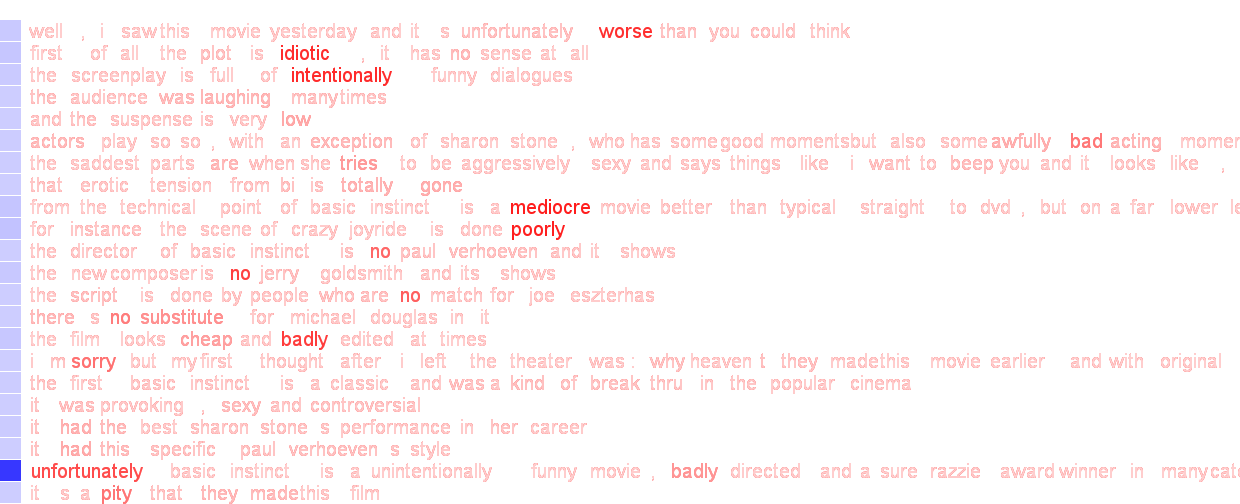

In [140]:
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch = next(batches_split)
    fd = {model.is_training: True, model.inputs_embedded: data, 
          model.word_lengths: words_per_sent_per_doc,
          model.sentence_lengths: sent_per_doc, model.labels: labels_batch, 
          model.sample_weights: np.ones(shape=(10))}
    sent_atts, word_atts = s.run([model.sentence_attentions, model.word_attentions], feed_dict=fd)
    
    sents = sents_batch[0]  # list of sentenses
    sent_atts = np.squeeze(sent_atts[0, :len(sents)])  # array of sent attentions
    word_atts = np.squeeze(word_atts[:len(sents), :])  # array of word attentions
    
    im = draw_text_att(sents, sent_atts, word_atts)

im

### The Good, The Bad and The Attention

In [178]:
iters = 500
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)
good_good, good_bad, bad_bad, bad_good = [], [], [], []  # word_label
with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in enumerate(batches_split):
        fd = {model.is_training: True, model.inputs_embedded: data, 
              model.word_lengths: words_per_sent_per_doc,
              model.sentence_lengths: sent_per_doc, model.labels: labels_batch, 
              model.sample_weights: np.ones(shape=(10))}
        sent_atts, word_atts = s.run([model.sentence_attentions, model.word_attentions], feed_dict=fd)
        
        x = 0
        for sents, label in zip(sents_batch, labels_batch):
            for sent in sents:
                for y, word in enumerate(sent):
                    wa = word_atts[x, y]
                    if word == 'good' and label == 1:
                        good_good.append(wa)
                    if word == 'bad' and label == 1:
                        bad_good.append(wa)
                    if word == 'good' and label == 0:
                        good_bad.append(wa)
                    if word == 'bad' and label == 0:
                        bad_bad.append(wa)
                x += 1
            x += 1

        if i % 50 == 0:
            print('iteration={}'.format(i))
        if i == iters:
            break

Reading model parameters from checkpoints/checkpoint-2500
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2500
iteration=0
iteration=50
iteration=100
iteration=150
iteration=200
iteration=250
iteration=300
iteration=350
iteration=400
iteration=450
iteration=500


In [187]:
good_good = np.squeeze(np.array(good_good))
good_bad = np.squeeze(np.array(good_bad))
bad_good = np.squeeze(np.array(bad_good))
bad_bad = np.squeeze(np.array(bad_bad))

In [210]:
arrays = {
    'good_good': good_good, 'good_bad': good_bad, 
    'bad_good': bad_good, 'bad_bad': bad_bad
}

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


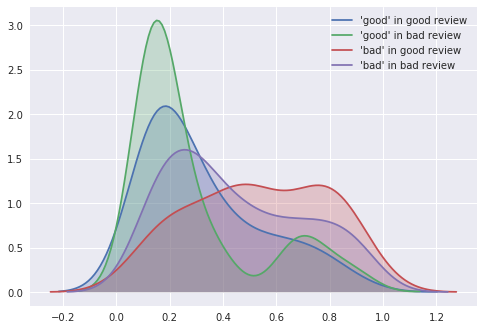

In [226]:
for word, label in itertools.product(['good', 'bad'], ['good', 'bad']):
    name = f'{word}_{label}'
    array = arrays[name]
    sns.kdeplot(array[array >= 0.1], shade=True, label=f'\'{word}\' in {label} review')
plt.legend();

### The Attention vs The Absense of Attention

rnn-based model

In [239]:
iters = 300
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s, attention=False)
    cum_acc = 0.
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in enumerate(batches_split):
        fd = {model.is_training: False, model.inputs_embedded: data, 
              model.word_lengths: words_per_sent_per_doc,
              model.sentence_lengths: sent_per_doc, model.labels: labels_batch, 
              model.sample_weights: np.ones(shape=(10))}
        cum_acc += s.run(model.accuracy, feed_dict=fd)
        if i % 50 == 0:
            print('iteration={} acc={}'.format(i, cum_acc / i if i != 0 else float('inf')))
        if i == iters:
            break

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
iteration=0 acc=inf
iteration=50 acc=0.6120000150799751
iteration=100 acc=0.6080000159144402
iteration=150 acc=0.594666682779789
iteration=200 acc=0.6020000174641609
iteration=250 acc=0.5940000165700913
iteration=300 acc=0.5830000159641107


singe-word-attention model

In [231]:
iters = 300
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    cum_acc = 0.
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in enumerate(batches_split):
        fd = {model.is_training: False, model.inputs_embedded: data, 
              model.word_lengths: words_per_sent_per_doc,
              model.sentence_lengths: sent_per_doc, model.labels: labels_batch, 
              model.sample_weights: np.ones(shape=(10))}
        cum_acc += s.run(model.accuracy, feed_dict=fd)
        if i % 50 == 0:
            print('iteration={} acc={}'.format(i, cum_acc / i if i != 0 else float('inf')))
        if i == iters:
            break

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


iteration=0 acc=inf
iteration=50 acc=0.6060000136494637
iteration=100 acc=0.5740000128746032
iteration=150 acc=0.556666680375735
iteration=200 acc=0.5505000133812428
iteration=250 acc=0.5640000131130218
iteration=300 acc=0.5746666803459326
